In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np 
#import os 
import pickle as plk
#import cv2
from io import BytesIO
from functools import partial
import PIL.Image
from IPython.display import clear_output, Image, display, HTML
from __future__ import print_function

In [2]:
#'''A Convolutional Network implementation example using TensorFlow library.
# Parameters
num_train=50000
num_channel=3
num_test=5000
num_class=10
learning_rate = 0.001
training_iters =7000
batch_size = 256
display_step = 10
keep_prob=0.5
training=1 # it needs dropout when training
testing=-1 # not need to dropout when testing
dropout=0
n_classes = 10 #  (0-9 digits)

#author wenting li 

def preprocess_data(num_class,num_train,num_test):
    f=open("H:/04_course/16deep_learning/Homework/Prog4/cifar_10_tf_train_test.pkl", "rb")
    train_x, train_y, test_x, test_y = plk.load(f,encoding='latin1') 
    # converting float32
    train_x=np.float32(train_x)
    train_y=np.int32(train_y)
    test_x=np.float32(test_x)
    test_y=np.int32(test_y)
    # scaling and normalize 
    X=train_x-np.mean(train_x)
    X=X/np.std(X)
    Y=np.zeros((num_train,num_class))
    Y[np.arange(num_train),train_y]=1
    X_test=test_x-np.mean(test_x)
    X_test=X_test/np.std(X_test)
    Y_test=np.zeros((num_test,num_class))
    Y_test[np.arange(num_test),test_y]=1
    return X,Y,X_test,Y_test 
def lrelu(x, alpha=0., max_value=None):
    negative_part = tf.nn.relu(-x)
    x = tf.nn.relu(x)
    if max_value is not None:
        x = tf.clip_by_value(x, tf.cast(0., dtype=tf.float32),
                             tf.cast(max_value, dtype=tf.float32))
    x -= tf.constant(alpha, dtype=tf.float32) * negative_part
    return x
 
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID') 
    x = tf.nn.bias_add(x, b) 
    #return lrelu(x)
    return tf.nn.relu(x) # 

def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='VALID') # 
 
# Create model
def conv_net(training, x, weights, biases, keep_prob): # weights are dictionaries
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 32,32, 3])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)
    conv1=tf.cond(training, lambda: tf.nn.dropout(conv1,keep_prob=0.9 if dropout else 1.0) ,lambda: conv1) 
 

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2) 
    conv2=tf.cond(training, lambda: tf.nn.dropout(conv2,keep_prob=0.8 if dropout else 1.0) ,lambda: conv2) 
    
    # Convolution Layer
    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    # Max Pooling (down-sampling)
    #conv3 = maxpool2d(conv3, k=2)  
    conv3=tf.cond(training, lambda: tf.nn.dropout(conv3,keep_prob=0.7 if dropout else 1.0) ,lambda: conv3) 
    
    # Fully connected layer
    # Reshape conv3 output to fit fully connected layer input
    fc1 = tf.reshape(conv3, [-1, weights['out'].get_shape().as_list()[0]])  
    # Apply Dropout
    fc1=tf.cond(training, lambda: tf.nn.dropout(fc1,keep_prob=keep_prob) ,lambda: fc1) 
    #tf.nn.dropout(fc1,keep_prob=keep_prob)
    #fc1=tf.cond(training, lambda: tf.nn.dropout(fc1,keep_prob=0.75 if dropout else 1.0) ,lambda: fc1) 

    # Output, class prediction
    out= tf.add(tf.matmul(fc1, weights['out']), biases['out']) 
    return out

def input_weight_all(Theta,name):# Theta is a list type
    import pickle
    filepointer=open(name,"wb")
    pickle.dump(Theta,filepointer,protocol=2)
    filepointer.close()
    return



In [3]:
def establish_model(train_data,train_labels,eval_data,eval_labels):
    global keep_prob,training,testing,dropout,learning_rate, training_iters,display_step,batch_size 
    x = tf.placeholder(tf.float32, [None, 32,32,3])
    y = tf.placeholder(tf.int32, [None, 10])
     # Store layers weight & bias
    weights = {
    # 5x5 conv, 3 input, 32 outputs
      'wc1': tf.get_variable( 'weight1',shape = [5, 5, 3, 32],
        initializer = tf.contrib.layers.xavier_initializer_conv2d(uniform=True, seed=None, dtype=tf.float32)),    
    # 5x5 conv, 32 inputs, 32 outputs
      'wc2': tf.get_variable( 'weight2',shape = [5, 5, 32, 32],
        initializer = tf.contrib.layers.xavier_initializer_conv2d(uniform=True, seed=None, dtype=tf.float32)), #tf.Variable(tf.random_normal([5, 5, 32, 32])),
    # 3x3 conv, 32 inputs, 64 outputs
      'wc3': tf.get_variable( 'weight3',shape = [3,3, 32, 64],
        initializer = tf.contrib.layers.xavier_initializer_conv2d()),#tf.Variable(tf.random_normal([3, 3, 32, 64])),
    # fully connected, 3*3*64 inputs, 1024 outputs
      'out':  tf.get_variable( 'weight_out',shape = [3*3*64, 10],
        initializer = tf.contrib.layers.xavier_initializer()) #tf.Variable(tf.random_normal([3*3*64, n_classes ])),
    # 1024 inputs, 10 outputs (class prediction)
    #'out': tf.Variable(tf.random_normal([1024, n_classes]))
        }
    biases = {
      'bc1': tf.get_variable( 'bias1',
          shape = [32],
          initializer=tf.constant_initializer(0.0)),# tf.Variable(tf.random_normal([28,28,32])),# could not understant the dim
      'bc2': tf.get_variable(  'bias2',
          shape = [32],
          initializer=tf.constant_initializer(0.0)),#tf.Variable(tf.random_normal([10,10,32])),
      'bc3':tf.get_variable(  'bias3',
          shape = [64],
          initializer=tf.constant_initializer(0.0)), #tf.Variable(tf.random_normal([3,3,64])),
      #'bd1': tf.Variable(tf.random_normal([1024])),
      'out': tf.get_variable(  'out',
          shape = [n_classes],
          initializer=tf.constant_initializer(0.0))#tf.Variable(tf.random_normal([n_classes]))
        }
        # Construct model
    pred = conv_net(tf.greater(training,0), x, weights, biases, keep_prob)
    predict_op=tf.argmax(tf.nn.softmax(pred), 1)
    step=1
    loss_list=[]
    train_rate=[]
    test_rate=[]
    # Define loss and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
    #optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate/np.sqrt(step)).minimize(cost) # return the pairs  of vatiables and weight
    optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate/np.sqrt(step), decay=0.8).minimize(cost)
    correct = tf.equal(predict_op, tf.argmax(y, 1))
    err=1- tf.reduce_mean(tf.cast(correct, tf.float32))
    # Evaluate model
    pred_test=conv_net(tf.greater(testing,0),x, weights, biases, keep_prob)
    correct_test = tf.equal(tf.argmax(tf.nn.softmax(pred_test), 1), tf.argmax(y, 1))
    err_test = 1-tf.reduce_mean(tf.cast(correct_test, tf.float32))
 
    # Initializing the variables
     
    #save
    saver = tf.train.Saver()
    # Launch the graph
    sess = tf.InteractiveSession()
    # Initializing the variables
    init = tf.global_variables_initializer()
    sess.run(init)
    while step < training_iters:
        ind = np.arange(train_data.shape[0])
        batch_idx = np.random.choice(ind, batch_size, replace=False)
        batch_x = train_data[batch_idx]
        batch_y= train_labels[batch_idx]
        indtest = np.arange(eval_data.shape[0])
        test_idx = np.random.choice(indtest, batch_size, replace=False)
        batch_xtest=eval_data[test_idx]
        batch_ytest=eval_labels[test_idx]
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y  })
        loss, train_err = sess.run([cost, err], feed_dict={x: batch_x, y: batch_y })
        test_err=sess.run(err_test, feed_dict={x: batch_xtest, y: batch_ytest })
        loss_list.append(loss)
        train_rate.append(train_err)
        test_rate.append(test_err)
        if step % display_step == 0:
            # Calculate batch loss and err
            print("Iter " + str(step ) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", testing err= " + \
                  "{:.5f}".format(test_err)+ ", training err= " + \
                  "{:.5f}".format(train_err))
        step += 1
    correct_results=sess.run(correct_test, feed_dict={x:eval_data, y:eval_labels })
    total_test=sess.run(err_test, feed_dict={x:eval_data, y:eval_labels })
    print("Testing err:", total_test)    
    print("Optimization Finished!")
    # Create the collection.
    tf.get_collection("validation_nodes")
    # Add stuff to the collection.
    tf.add_to_collection("validation_nodes", x)
    tf.add_to_collection("validation_nodes", predict_op) 
    save_path = saver.save(sess, "C:/Users/Lab/my_model")   
    w1=weights['wc1'].eval()
    b1=biases['bc1'].eval()
    input_weight_all(weights['wc1'].eval(),'w1')
    input_weight_all(weights['wc2'].eval(),'w2')
    input_weight_all(weights['wc3'].eval(),'w3')
    input_weight_all(weights['out'].eval(),'wout')
    return loss_list,step,train_rate,test_rate, correct_results,w1,b1

In [4]:
def plot_loss(loss,train_step,from_second,name_save, plot_name,plot_title):
    if from_second :
        plt.plot(range(0,train_step-1,1),loss[1:])
    else:
        plt.plot(range(0,train_step,1),loss[0:])
    plt.xlabel('Iterative times (t)')
    plt.ylabel(plot_name)
    plt.title(plot_title)
    plt.grid(True)
    plt.savefig(name_save)
    plt.show() 

In [5]:
def each_perform(correct_results,eval_labels,num_test):
    label_y=np.argmax(eval_labels,1)
    
    zero = np.where(label_y==0)
    correct=[correct_results[i] for i in zero]
    accuracy_zero=1-np.mean(correct)

    one = np.where(label_y==1)
    correct=[correct_results[i] for i in one]
    accuracy_one=1-np.mean(correct)

    two = np.where(label_y==2)
    correct=[correct_results[i] for i in two]
    accuracy_two=1-np.mean(correct)

    three = np.where(label_y==3)
    correct=[correct_results[i] for i in three]
    accuracy_three=1-np.mean(correct)

    four = np.where(label_y==4)
    correct=[correct_results[i] for i in four]
    accuracy_four=1-np.mean(correct)

    five = np.where(label_y==5)
    correct=[correct_results[i] for i in five]
    accuracy_five=1-np.mean(correct)

    six = np.where(label_y==6)
    correct=[correct_results[i] for i in six]
    accuracy_six=1-np.mean(correct)

    seven = np.where(label_y==7)
    correct=[correct_results[i] for i in seven]
    accuracy_seven=1-np.mean(correct)

    eight = np.where(label_y==8)
    correct=[correct_results[i] for i in eight]
    accuracy_eight=1-np.mean(correct)

    nine = np.where(label_y==9)
    correct=[correct_results[i] for i in nine]
    accuracy_nine=1-np.mean(correct)
    print(accuracy_zero)
    print(accuracy_one)
    print(accuracy_two)
    print(accuracy_three)
    print(accuracy_four)
    print(accuracy_five)
    print(accuracy_six)
    print(accuracy_seven)
    print(accuracy_eight)
    print(accuracy_nine)
   

In [6]:
def visulize(w1,b1,nth):   
    img_noise = np.random.uniform(size=(1,32,32,3)) + 100.0
    t_input = tf.placeholder(np.float32, name='input') # define the input tensor
    sess = tf.InteractiveSession()
    init = tf.global_variables_initializer()
    sess.run(init)
    #w1= weights['wc1'] #weights['wc1']#
    #b= biases['bc1']  #biases['bc1']#
    first_layers = conv(t_input,w1,b1)
    layer=first_layers[:,:,:,nth]
    t_score=tf.reduce_mean(layer)
    t_grad=tf.gradients(t_score,t_input)[0]
    img=img_noise.copy()
    iter_n=20
    step=10
    for i in range(iter_n):
        score, g = sess.run([t_score, t_grad], feed_dict={t_input: img})
        # normalizing the gradient, so the same step size should work
        g /= g.std()+1e-8# for different layers and networks
        img+=g*step
    showarray(visstd(img[0,:,:,:]),nth)   
         
def conv(x,W,b):
    x = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='VALID')
    #b=tf.tile(tf.expand_dims(b,0),[x.get_shape().as_list()[0],1,1,1])
    x = tf.nn.bias_add(x, b) 
    return  tf.nn.relu(x)
 
def showarray(a,nth, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 1)*255)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    im=PIL.Image.fromarray(a)
    display(Image(data=f.getvalue())) 
    im.save('H:/04_course/16deep_learning/Homework/Prog4/'+str(nth)+'.jpeg')
    
def visstd(a, s=0.1):
    '''Normalize the image range for visualization'''
    return (a-a.mean())/max(a.std(), 1e-4)*s + 0.5
  

Iter 10, Minibatch Loss= 2.351961, testing err= 0.90625, training err= 0.88281
Iter 20, Minibatch Loss= 2.292764, testing err= 0.88281, training err= 0.87500
Iter 30, Minibatch Loss= 2.278208, testing err= 0.86328, training err= 0.88281
Iter 40, Minibatch Loss= 2.179152, testing err= 0.76172, training err= 0.80859
Iter 50, Minibatch Loss= 2.071568, testing err= 0.70703, training err= 0.76172
Iter 60, Minibatch Loss= 1.981883, testing err= 0.74219, training err= 0.73438
Iter 70, Minibatch Loss= 1.938652, testing err= 0.76562, training err= 0.73047
Iter 80, Minibatch Loss= 1.911443, testing err= 0.67969, training err= 0.70312
Iter 90, Minibatch Loss= 1.796932, testing err= 0.65625, training err= 0.67188
Iter 100, Minibatch Loss= 1.811297, testing err= 0.67188, training err= 0.64062
Iter 110, Minibatch Loss= 1.739678, testing err= 0.61719, training err= 0.62109
Iter 120, Minibatch Loss= 1.659437, testing err= 0.60156, training err= 0.59375
Iter 130, Minibatch Loss= 1.606436, testing err= 

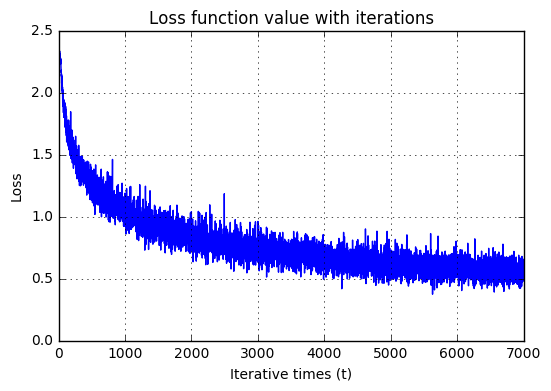

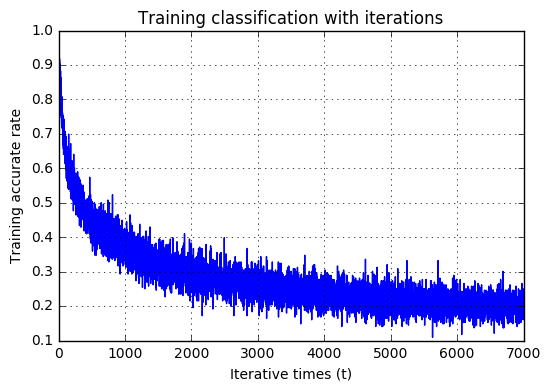

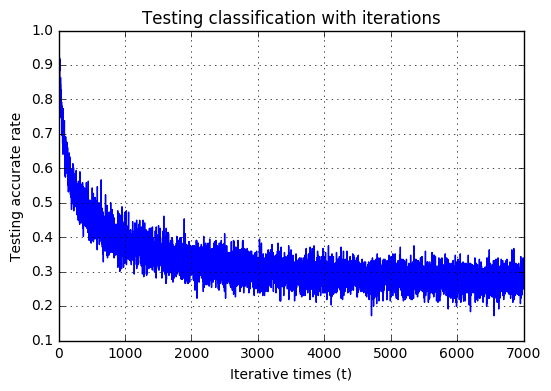

0.233606557377
0.0970297029703
0.36328125
0.434607645875
0.32741617357
0.454918032787
0.142566191446
0.286868686869
0.126984126984
0.214424951267


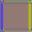

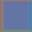

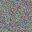

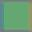

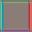

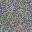

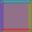

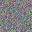

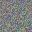

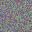

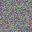

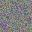

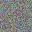

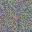

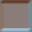

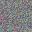

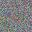

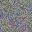

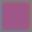

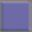

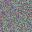

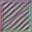

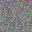

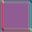

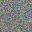

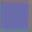

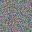

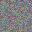

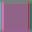

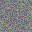

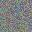

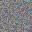

In [7]:
t=1
if t==1:
    #load data
    train_data,train_labels,eval_data,eval_labels=preprocess_data(num_class,num_train,num_test)
    loss,step,train_rate,test_rate, correct_results,w1,b1=establish_model(train_data,train_labels,eval_data,eval_labels)
    plot_loss(loss,step-1,False,"Loss_value.png", 'Loss','Loss function value with iterations') 
    plot_loss(train_rate,step-1,False,"Train_err_rate.png",'Training accurate rate','Training classification with iterations')
    plot_loss(test_rate,step-1,False,"Test_err_rate.png",'Testing accurate rate','Testing classification with iterations')
    each_perform(correct_results,eval_labels,5000)
    for i in range(32):
        visulize(w1,b1,i)

Iter 10, Minibatch Loss= 2.309555, testing err= 0.92188, training err= 0.89844
Iter 20, Minibatch Loss= 2.300452, testing err= 0.85156, training err= 0.89453
Iter 30, Minibatch Loss= 2.281193, testing err= 0.84375, training err= 0.88281
Iter 40, Minibatch Loss= 2.143622, testing err= 0.83984, training err= 0.78125
Iter 50, Minibatch Loss= 2.014917, testing err= 0.75000, training err= 0.70703
Iter 60, Minibatch Loss= 1.820508, testing err= 0.75000, training err= 0.66406
Iter 70, Minibatch Loss= 1.754632, testing err= 0.75781, training err= 0.66406
Iter 80, Minibatch Loss= 1.797013, testing err= 0.64453, training err= 0.66406
Iter 90, Minibatch Loss= 1.799274, testing err= 0.65234, training err= 0.66797
Iter 100, Minibatch Loss= 1.642427, testing err= 0.64062, training err= 0.52734
Iter 110, Minibatch Loss= 1.709946, testing err= 0.56641, training err= 0.58594
Iter 120, Minibatch Loss= 1.580376, testing err= 0.64844, training err= 0.56641
Iter 130, Minibatch Loss= 1.597405, testing err= 

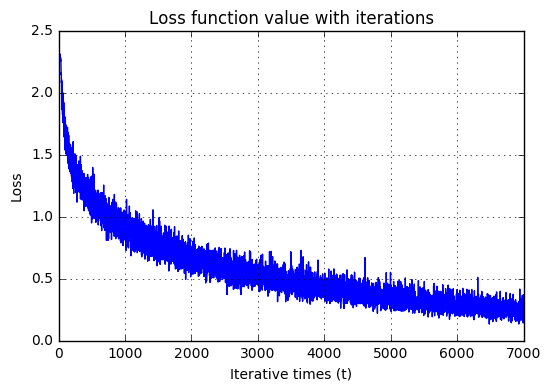

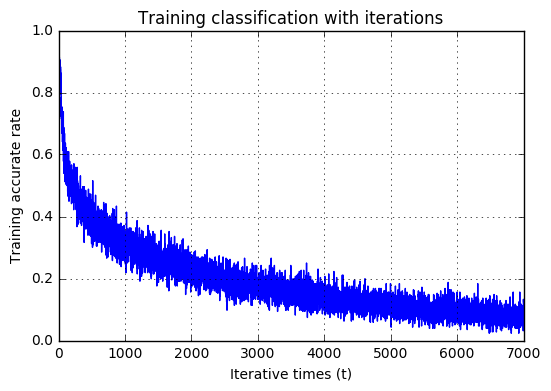

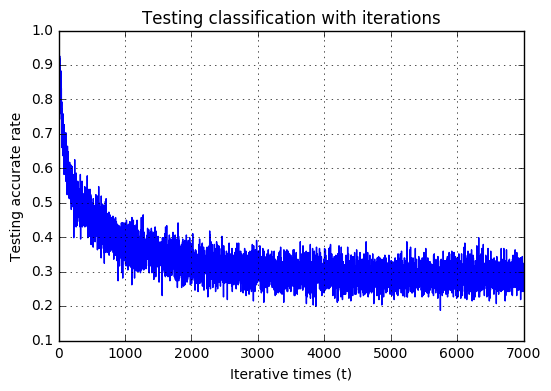

0.28893442623
0.122772277228
0.609375
0.478873239437
0.400394477318
0.381147540984
0.279022403259
0.151515151515
0.236111111111
0.144249512671


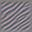

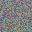

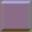

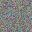

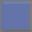

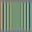

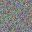

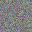

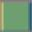

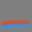

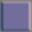

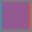

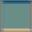

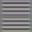

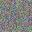

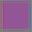

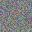

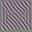

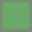

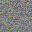

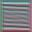

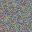

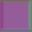

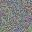

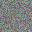

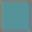

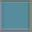

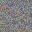

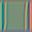

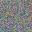

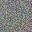

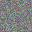

In [7]:
t=1
if t==1:
    #load data
    train_data,train_labels,eval_data,eval_labels=preprocess_data(num_class,num_train,num_test)
    loss,step,train_rate,test_rate, correct_results,w1,b1=establish_model(train_data,train_labels,eval_data,eval_labels)
    plot_loss(loss,step-1,False,"Loss_value.png", 'Loss','Loss function value with iterations') 
    plot_loss(train_rate,step-1,False,"Train_err_rate.png",'Training accurate rate','Training classification with iterations')
    plot_loss(test_rate,step-1,False,"Test_err_rate.png",'Testing accurate rate','Testing classification with iterations')
    each_perform(correct_results,eval_labels,5000)
    for i in range(32):
        visulize(w1,b1,i)

In [8]:
if __name__ == '__main__':
    main()

Iter 10, Minibatch Loss= 2.313967, testing err= 0.84375, training err= 0.89844
Iter 20, Minibatch Loss= 2.288524, testing err= 0.92188, training err= 0.85156
Iter 30, Minibatch Loss= 2.267105, testing err= 0.83594, training err= 0.85547
Iter 40, Minibatch Loss= 2.152132, testing err= 0.78516, training err= 0.74219
Iter 50, Minibatch Loss= 2.082893, testing err= 0.74219, training err= 0.74219
Iter 60, Minibatch Loss= 1.993623, testing err= 0.75000, training err= 0.71094
Iter 70, Minibatch Loss= 1.890586, testing err= 0.70312, training err= 0.66406
Iter 80, Minibatch Loss= 1.942773, testing err= 0.68750, training err= 0.65625
Iter 90, Minibatch Loss= 1.744138, testing err= 0.63672, training err= 0.60938
Iter 100, Minibatch Loss= 1.573217, testing err= 0.69922, training err= 0.56641
Iter 110, Minibatch Loss= 1.728325, testing err= 0.64453, training err= 0.60938
Iter 120, Minibatch Loss= 1.616122, testing err= 0.61719, training err= 0.55078
Iter 130, Minibatch Loss= 1.593956, testing err= 

KeyboardInterrupt: 